In [1]:
import osmnx as ox
import folium
import pandas as pd
import matplotlib.pyplot as plt
from networkx import DiGraph, MultiDiGraph
from shapely.geometry import LineString
from tqdm import tqdm
from coord_convert.transform import wgs2gcj

In [ ]:
# Please first download the dataset from our figshare repository

In [2]:
# Read Road Network
nodes = pd.read_csv("../dataset/node_shenzhen.csv")
nodes = [
    (
        int(nid), 
        {
            "id": int(nid),
            "x": float(lon),
            "y": float(lat),
            "has_camera": bool(hasc)
        }
    ) for _, (nid, lon, lat, hasc) in nodes.iterrows()
]
edges = pd.read_csv("../dataset/edge_shenzhen.csv")
edges = [
    (
        int(o),
        int(d), 
        {
            "id": i,
            "od": [int(o), int(d)], 
            "class": c,
            "points": [[float(x) for x in p.split("-")] for p in geo.split("_")],
            "length": float(l)
        }
    ) for i, (_, (o, d, c, geo, l)) in enumerate(edges.iterrows())
]
for e in edges:
    e[2]["geometry"] = LineString(e[2]["points"])
print("nodes:", len(nodes))
print("edges:", len(edges))
G = DiGraph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)
G.graph["crs"] = "+proj=tmerc +lat_0=22.6433 +lon_0=114.0139"

nodes: 11933
edges: 27410


<Figure size 640x480 with 0 Axes>

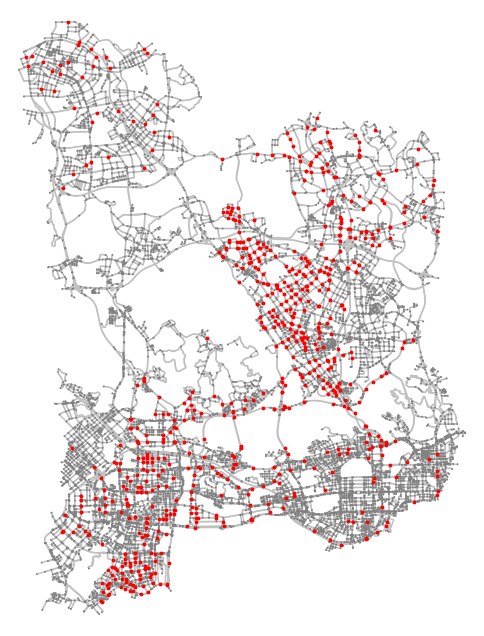

In [3]:
# Plot Road Network
plt.figure()
ox.plot_graph(MultiDiGraph(G), node_size=2, bgcolor='white', node_color='gray', edge_color='silver', show=False)
for _, n in G.nodes(data=True):
    if n["has_camera"]:
        plt.scatter(n["x"], n["y"], c="red", s=3)
plt.show()

In [4]:
# Read Trajectory
trajs = pd.read_csv("../dataset/traj_shenzhen_20210824.csv")
trajs = [
    {
        "vid": vid,
        "tid": tid,
        "ps": [[int(p.split("-")[0]), float(p.split("-")[1])] for p in ps.split("_")],
        "dt": dt,
        "dr": dr,
        "l": l
    } for _, (vid, tid, ps, dt, dr, l) in tqdm(trajs.iterrows())
]
print("trajs:", len(trajs))

1686464it [04:00, 7021.35it/s] 


trajs: 1686464


In [5]:
# Plot Trajectory
m = folium.Map(location=[22.6433, 114.0139], control_scale=True, zoom_start=13)
traj = [x for x in trajs if x["vid"] == 211624][0]
for (n1, t1), (n2, t2) in zip(traj["ps"], traj["ps"][1:]):
    folium.CircleMarker(
        location=[G.nodes[n1]["y"], G.nodes[n1]["x"]],
        radius=5,
        opacity=0.6,
        popup=t1
    ).add_to(m)
    folium.PolyLine(
        locations=[p[::-1] for p in G.edges[n1, n2]["points"]],
        weight=5,
        opacity=0.6
    ).add_to(m)
folium.CircleMarker(
    location=[G.nodes[n2]["y"], G.nodes[n2]["x"]],
    radius=5,
    opacity=0.6,
    popup=t1
).add_to(m)
m.save("test_wgs.html")  # open this html to see

In [42]:
# Plot Trajectory on a GCJ02-coordinated map
m = folium.Map(
    location=[22.6433, 114.0139], control_scale=True, zoom_start=13, attr="amap tiles",
    tiles='http://webrd02.is.autonavi.com/appmaptile?lang=zh_cn&size=1&scale=1&style=8&x={x}&y={y}&z={z}')
for (n1, t1), (n2, t2) in zip(traj["ps"], traj["ps"][1:]):
    folium.CircleMarker(
        location=wgs2gcj(G.nodes[n1]["x"], G.nodes[n1]["y"])[::-1],
        radius=5,
        opacity=0.6,
        popup=t1
    ).add_to(m)
    folium.PolyLine(
        locations=[wgs2gcj(*p)[::-1] for p in G.edges[n1, n2]["points"]],
        weight=5,
        opacity=0.6
    ).add_to(m)
folium.CircleMarker(
    location=wgs2gcj(G.nodes[n1]["x"], G.nodes[n1]["y"])[::-1],
    radius=5,
    opacity=0.6,
    popup=t1
).add_to(m)
m.save("test_gcj.html")  # open this html to see